# Finding optimal adjustment sets

### Preliminaries

This notebook illustrates the use of the algorithms developed in [Smucler, Sapienza and Rotnitzky (Biometrika, 2022)](https://arxiv.org/abs/1912.00306) and [Smucler and Rotnitzky (Journal of Causal Inference, 2022)](https://www.degruyter.com/document/doi/10.1515/jci-2022-0015/html) to compute backdoor sets that yield efficient estimators of interventional means and their contrasts (such as the ATE), under various constraints. We begin by recalling some definitions from these papers. We ommit most technical details, and point the reader to the original papers for them.

The **optimal backdoor set** is a backdoor set comprised of observable variables that yields non-parametric
estimators of the interventional mean with the smallest asymptotic variance
among those that are based on observable backdoor sets. This optimal backdoor
set always exists when no variables are latent, and the algorithm is guaranteed to compute
it in this case. Under a non-parametric graphical model with latent variables,
such a backdoor set can fail to exist. 

The **optimal minimal backdoor set** is a minimal backdoor set comprised of observable variables that yields non-parametric
estimators of the interventional mean with the smallest asymptotic variance
among those that are based on observable minimal backdoor sets.

The **optimal minimum cost backdoor set** is a minimum cost backdoor set comprised of observable variables that yields non-parametric estimators of the interventional mean with the smallest asymptotic variance
among those that are based on observable minimum cost backdoor sets. The cost
of a backdoor set is defined as the sum of the costs of the variables that comprise it. Note that 
when all costs are equal, the optimal minimum cost backdoor set is the optimal backdoor set among those that 
have minimum cardinality.

These various optimal backdoor sets are not only optimal under
non-parametric graphical models and non-parametric estimators of interventional mean,
but also under linear graphical models and OLS estimators, per results in [Henckel, Perkovic
and Maathuis (JRSS B, 2022)](https://arxiv.org/abs/1907.02435).

### The design of an observational study

In [1]:
from dowhy.causal_graph import CausalGraph
from dowhy.causal_identifier import AutoIdentifier, BackdoorAdjustment, EstimandType
from dowhy.graph import build_graph_from_str
from dowhy.utils.plotting import plot

Consider the design of the following hypothetical observational study discussed in [Shrier & Platt (2008)](https://doi.org/10.1186/1471-2288-8-70). The aim of the study is to assess the
effect of warm-up exercises on injury after playing sports. Suppose that a researcher postulates
that the graph below represents a causal graphical model. The node warm-up is the treatment variable, which stands for the type of exercise an athlete performs prior to playing sports,
and the node injury stands for the outcome variable. 

Suppose that the goal of the study is to estimate and
compare the interventional means corresponding to different individualised treatment rules. Each
rule prescribes the type of warm-up exercise as a function of previous injury and team motivation. For example, one such rule could be to allocate a patient to perform soft warm-up excercises when she has previous injury = 1 and team motivation > 6, but any other (possibly randomised) function of previous injury and team motivation to set the treatment variable could be of interest. More formally, the goal of the study is, for some set of policies such as the aforementioned one, to estimate the mean of the outcome, in a world in which all patients are allocated to a treatment variant according to one of these policies. We will suppose moreover that due to practical limitations, the variables genetics, pre-grame proprioception,
intra-game proprioception and tissue weakness cannot be measured. Proprioception is an individual's ability to sense the movement, action, and location of their own bodies.

To build the graph, we first create a string declaring the graph's nodes and edges. We then create a list of all observable variables, in this case, all variables in the graph except genetics, pre-game proprioception, intra-game proprioception and tissue weakness. We then pass all this information to the ```CausalGraph``` class, to create an instance of it.

In [2]:
graph_str = """graph[directed 1 node[id "coach" label "coach"]
                        node[id "team motivation" label "team motivation"]
                        node[id "fitness" label "fitness"]
                        node[id "pre-game prop" label "pre-game prop"]
                        node[id "intra-game prop" label "intra-game prop"]                       
                        node[id "neuromusc fatigue" label "neuromusc fatigue"]
                        node[id "warm-up" label "warm-up"]
                        node[id "previous injury" label "previous injury"]
                        node[id "contact sport" label "contact sport"]
                        node[id "genetics" label "genetics"]
                        node[id "injury" label "injury"]
                        node[id "tissue disorder" label "tissue disorder"]
                        node[id "tissue weakness" label "tissue weakness"]
                        edge[source "coach" target "team motivation"]
                        edge[source "coach" target "fitness"]
                        edge[source "fitness" target "pre-game prop"]
                        edge[source "fitness" target "neuromusc fatigue"]
                        edge[source "team motivation" target "warm-up"]
                        edge[source "team motivation" target "previous injury"]
                        edge[source "pre-game prop" target "warm-up"]
                        edge[source "warm-up" target "intra-game prop"]
                        edge[source "contact sport" target "previous injury"]
                        edge[source "contact sport" target "intra-game prop"]
                        edge[source "intra-game prop" target "injury"]
                        edge[source "genetics" target "fitness"]
                        edge[source "genetics" target "neuromusc fatigue"]
                        edge[source "genetics" target "tissue disorder"]
                        edge[source "tissue disorder" target "neuromusc fatigue"]
                        edge[source "tissue disorder" target "tissue weakness"]
                        edge[source "neuromusc fatigue" target "intra-game prop"]
                        edge[source "neuromusc fatigue" target "injury"]
                        edge[source "tissue weakness" target "injury"]
                        ]
"""
observed_node_names = [
    "coach",
    "team motivation",
    "fitness",
    "neuromusc fatigue",
    "warm-up",
    "previous injury",
    "contact sport",
    "tissue disorder",
    "injury",
]
treatment_name = "warm-up"
outcome_name = "injury"
G = build_graph_from_str(graph_str)

We can easily create a plot of the graph using the ```view_graph``` method.

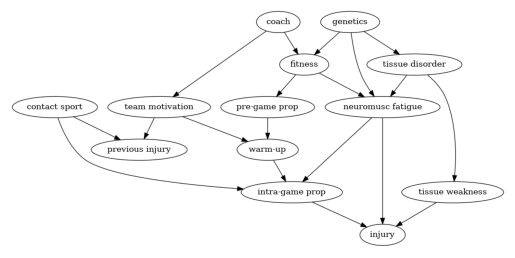

In [3]:
plot(G)

Next, we illustrate how to compute the backdoor sets defined in the preliminaries section for the example graph above, using the ```CausalIdentifier``` class. To compute the optimal backdoor set, optimal minimal backdoor set and optimal minimum cost backdoor set, we need to instantiate objects of the ```CausalIdentifier``` class, passing as ```method_name``` the values "efficient-adjustment", "efficient-minimal-adjustment" and "efficient-mincost-adjustment" respectively. Then, we need to call the ```identify_effect``` method, passing as an argument a list of conditional nodes, that is, the nodes that would be used to decide how to allocate treatment. As discussed above, in this example these nodes are previous injury and team motivation. For settings in which we are not interested in individualized interventions, we can just pass an empty list as conditional nodes.

In [4]:
conditional_node_names = ["previous injury", "team motivation"]

In [5]:
ident_eff = AutoIdentifier(
    estimand_type=EstimandType.NONPARAMETRIC_ATE,
    backdoor_adjustment=BackdoorAdjustment.BACKDOOR_EFFICIENT,
)
print(
    ident_eff.identify_effect(
        graph=G, 
        action_nodes=treatment_name, 
        outcome_nodes=outcome_name,
        observed_nodes=observed_node_names,
        conditional_node_names=conditional_node_names
    )
)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                         
──────────(E[injury|team motivation,tissue disorder,contact sport,neuromusc fa
d[warm-up]                                                                    

                       
tigue,previous injury])
                       
Estimand assumption 1, Unconfoundedness: If U→{warm-up} and U→injury then P(injury|warm-up,team motivation,tissue disorder,contact sport,neuromusc fatigue,previous injury,U) = P(injury|warm-up,team motivation,tissue disorder,contact sport,neuromusc fatigue,previous injury)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Thus, the optimal backdoor set is formed by previous injury, neuromusc fatigue, team motivation, tissue disorder and contact sport.

Similarly, we can compute the optimal minimal backdoor set.

In [6]:
ident_minimal_eff = AutoIdentifier(
    estimand_type=EstimandType.NONPARAMETRIC_ATE,
    backdoor_adjustment=BackdoorAdjustment.BACKDOOR_MIN_EFFICIENT,
)
print(
    ident_minimal_eff.identify_effect(
        graph=G, 
        action_nodes=treatment_name, 
        outcome_nodes=outcome_name, 
        observed_nodes=observed_node_names,
        conditional_node_names=conditional_node_names
    )
)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                         
──────────(E[injury|team motivation,tissue disorder,neuromusc fatigue,previous
d[warm-up]                                                                    

         
 injury])
         
Estimand assumption 1, Unconfoundedness: If U→{warm-up} and U→injury then P(injury|warm-up,team motivation,tissue disorder,neuromusc fatigue,previous injury,U) = P(injury|warm-up,team motivation,tissue disorder,neuromusc fatigue,previous injury)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Finally, we can compute the optimal minimum cost backdoor set. Since this graph does not have any costs associated with its nodes, we will not pass any costs to ```identify_effect```. The method will raise a warning, set the costs to one, and compute the optimal minimum cost backdoor set, which as stated above, in this case coincides with the optimal backdoor set of minimum cardinality.

In [7]:
ident_mincost_eff = AutoIdentifier(
    estimand_type=EstimandType.NONPARAMETRIC_ATE,
    backdoor_adjustment=BackdoorAdjustment.BACKDOOR_MINCOST_EFFICIENT,
)
print(
    ident_mincost_eff.identify_effect(
        graph=G, 
        action_nodes=treatment_name, 
        outcome_nodes=outcome_name,
        observed_nodes=observed_node_names,
        conditional_node_names=conditional_node_names
    )
)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                        
──────────(E[injury|team motivation,fitness,previous injury])
d[warm-up]                                                   
Estimand assumption 1, Unconfoundedness: If U→{warm-up} and U→injury then P(injury|warm-up,team motivation,fitness,previous injury,U) = P(injury|warm-up,team motivation,fitness,previous injury)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Later, we will compute the optimal minimum cost backdoor set for a graph with costs associated with its nodes.

### An example in which sufficient conditions to guarantee the existence of an optimal backdoor set do not hold

[Smucler, Sapienza and Rotnitzky (Biometrika, 2022)](https://arxiv.org/abs/1912.00306) proved that when all variables are observable, or when all observable variables are ancestors of either the treatment, outcome or conditional nodes, then an optimal backdoor set can be found solely based on the graph, and provided an algorithm to compute it. This is the algorithm implemented in the examples above. 

However, there exist cases in which an observable optimal backdoor sets cannot be found solely using graphical criteria. For the graph below, [Rotnitzky and Smucler (JMLR, 2021)](https://jmlr.csail.mit.edu/papers/volume21/19-1026/19-1026.pdf) in their Example 5 showed that depending on the law generating the data, the optimal backdoor set could be formed by Z1 and Z2, or be the empty set. More precisely, they showed that there exist probability laws compatible with the graph under which {Z1, Z2} is the most efficient adjustment set, and other probability laws under which the empty set is the most efficient adjustment set; unfortunately one cannot tell from the graph alone which of the two will be better. 

Notice that in this graph, the aforementioned sufficient condition for the existence of an optimal backdoor set does not hold, since Z2 is observable but not an ancestor of treatment outcome or the conditional nodes (the empty set in this case).  

On the other hand, [Smucler, Sapienza and Rotnitzky (Biometrika, 2022)](https://arxiv.org/abs/1912.00306) showed that optimal minimal and optimal minimum cost (cardinality) observable backdoor sets always exist, as long as there exists at least one backdoor set comprised of observable variables. That is, when the search is restricted to minimal or minimum cost (cardinality) backdoor sets, a situation such as the one described above cannot happen, and the most efficient backdoor set can always be detected based solely on graphical criteria.

For this example, calling the ```identify_effect``` method of an instance of ```CausalIdentifier``` with attribute ```method_name``` equal to "efficient-adjustment" will raise an error. For this graph, the optimal minimal and the optimal minimum cardinality backdoor sets are equal to the empty set.

In [8]:
graph_str = """graph[directed 1 node[id "X" label "X"]
                        node[id "Y" label "Y"]
                        node[id "Z1" label "Z1"]
                        node[id "Z2" label "Z2"]
                        node[id "U" label "U"]                       
                        edge[source "X" target "Y"]
                        edge[source "Z1" target "X"]
                        edge[source "Z1" target "Z2"]
                        edge[source "U" target "Z2"]
                        edge[source "U" target "Y"]
                        ]
"""
observed_node_names = ["X", "Y", "Z1", "Z2"]
treatment_name = "X"
outcome_name = "Y"
G = build_graph_from_str(graph_str)

In this example, the treatment intervention is static, thus there are no conditional nodes.

In [9]:
ident_eff = AutoIdentifier(
    estimand_type=EstimandType.NONPARAMETRIC_ATE,
    backdoor_adjustment=BackdoorAdjustment.BACKDOOR_EFFICIENT,
)
try:
    results_eff = ident_eff.identify_effect(graph=G, 
                                            action_nodes=treatment_name, 
                                            outcome_nodes=outcome_name,
                                            observed_nodes=observed_node_names)
except ValueError as e:
    print(e)

Conditions to guarantee the existence of an optimal adjustment set are not satisfied


In [10]:
ident_eff = AutoIdentifier(
    estimand_type=EstimandType.NONPARAMETRIC_ATE,
    backdoor_adjustment=BackdoorAdjustment.BACKDOOR_MIN_EFFICIENT,
)
print(
    ident_minimal_eff.identify_effect(
        graph=G,
        action_nodes=treatment_name,
        outcome_nodes=outcome_name,
        observed_nodes=observed_node_names
    )
)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                     -1⎤
 ⎢  d      ⎛  d       ⎞  ⎥
E⎢─────(Y)⋅⎜─────([X])⎟  ⎥
 ⎣d[Z₁]    ⎝d[Z₁]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z1})
Estimand assumption 2, Exclusion: If we remove {Z1}→{X}, then ¬({Z1}→Y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [11]:
ident_eff = AutoIdentifier(
    estimand_type=EstimandType.NONPARAMETRIC_ATE,
    backdoor_adjustment=BackdoorAdjustment.BACKDOOR_MINCOST_EFFICIENT,
)
print(
    ident_mincost_eff.identify_effect(
        graph=G,
        action_nodes=treatment_name,
        outcome_nodes=outcome_name,
        observed_nodes=observed_node_names
    )
)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                     -1⎤
 ⎢  d      ⎛  d       ⎞  ⎥
E⎢─────(Y)⋅⎜─────([X])⎟  ⎥
 ⎣d[Z₁]    ⎝d[Z₁]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z1})
Estimand assumption 2, Exclusion: If we remove {Z1}→{X}, then ¬({Z1}→Y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### An example in which there are no observable adjustment sets

In the graph below there are no adjustment sets comprised of only observable variables. In this setting, using any of the above methods will raise an error.

In [12]:
graph_str = """graph[directed 1 node[id "X" label "X"]
                        node[id "Y" label "Y"]
                        node[id "U" label "U"]                       
                        edge[source "X" target "Y"]
                        edge[source "U" target "X"]
                        edge[source "U" target "Y"]
                        ]
"""
observed_node_names = ["X", "Y"]
treatment_name = "X"
outcome_name = "Y"
G = build_graph_from_str(graph_str)

In [13]:
ident_eff = AutoIdentifier(
    estimand_type=EstimandType.NONPARAMETRIC_ATE,
    backdoor_adjustment=BackdoorAdjustment.BACKDOOR_EFFICIENT,
)
try:
    results_eff = ident_eff.identify_effect(
        graph=G,
        action_nodes=treatment_name,
        outcome_nodes=outcome_name,
        observed_nodes=observed_node_names
    )
except ValueError as e:
    print(e)

An adjustment set formed by observable variables does not exist


### An example with costs

This is the graph in Figures 1 and 2 of [Smucler and Rotnitzky (Journal of Causal Inference, 2022)](https://www.degruyter.com/document/doi/10.1515/jci-2022-0015/html). Here we assume that there are positive costs associated to observable variables.

In [14]:
graph_str = """graph[directed 1 node[id "L" label "L"]
                        node[id "X" label "X"]
                        node[id "K" label "K"]
                        node[id "B" label "B"]
                        node[id "Q" label "Q"]
                        node[id "R" label "R"]
                        node[id "T" label "T"]
                        node[id "M" label "M"]
                        node[id "Y" label "Y"]
                        node[id "U" label "U"]
                        node[id "F" label "F"]
                        edge[source "L" target "X"]
                        edge[source "X" target "M"]
                        edge[source "K" target "X"]
                        edge[source "B" target "K"]
                        edge[source "B" target "R"]
                        edge[source "Q" target "K"]
                        edge[source "Q" target "T"]
                        edge[source "R" target "Y"]
                        edge[source "T" target "Y"]
                        edge[source "M" target "Y"]
                        edge[source "U" target "Y"]
                        edge[source "U" target "F"]
                        ]
                        """
observed_node_names = ["L", "X", "B", "K", "Q", "R", "M", "T", "Y", "F"]
conditional_node_names = ["L"]
costs = [
    ("L", {"cost": 1}),
    ("B", {"cost": 1}),
    ("K", {"cost": 4}),
    ("Q", {"cost": 1}),
    ("R", {"cost": 2}),
    ("T", {"cost": 1}),
]
G = build_graph_from_str(graph_str)

Notice how in this case we pass both the ```conditional_node_names``` list and the ```costs``` list to the ```identify_effect``` method.

In [15]:
ident_eff = AutoIdentifier(
    estimand_type=EstimandType.NONPARAMETRIC_ATE,
    backdoor_adjustment=BackdoorAdjustment.BACKDOOR_MINCOST_EFFICIENT,
    costs=costs,
)
print(
    ident_mincost_eff.identify_effect(
        graph=G, 
        action_nodes=treatment_name, 
        outcome_nodes=outcome_name, 
        observed_nodes=observed_node_names,
        conditional_node_names=conditional_node_names
    )
)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d            
────(E[Y|K,L])
d[X]          
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,K,L,U) = P(Y|X,K,L)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([X])⎟  ⎥
 ⎣d[L]    ⎝d[L]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{L})
Estimand assumption 2, Exclusion: If we remove {L}→{X}, then ¬({L}→Y)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([M])⎥
 ⎣d[M]    d[X]     ⎦
Estimand assumption 1, Full-mediation: M intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{M} then P(M|X,U) = P(M|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{M} and U→Y then P(Y|M, X, U) = P(Y|M, X)



We also compute the optimal minimal backdoor set, which in this case is different from the optimal minimum cost backdoor set.

In [16]:
ident_eff = AutoIdentifier(
    estimand_type=EstimandType.NONPARAMETRIC_ATE,
    backdoor_adjustment=BackdoorAdjustment.BACKDOOR_MIN_EFFICIENT,
)
print(
    ident_minimal_eff.identify_effect(
        graph=G, 
        action_nodes=treatment_name,
        outcome_nodes=outcome_name, 
        observed_nodes=observed_node_names,
        conditional_node_names=conditional_node_names
    )
)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d              
────(E[Y|R,T,L])
d[X]            
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,R,T,L,U) = P(Y|X,R,T,L)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([X])⎟  ⎥
 ⎣d[L]    ⎝d[L]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{L})
Estimand assumption 2, Exclusion: If we remove {L}→{X}, then ¬({L}→Y)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([M])⎥
 ⎣d[M]    d[X]     ⎦
Estimand assumption 1, Full-mediation: M intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{M} then P(M|X,U) = P(M|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{M} and U→Y then P(Y|M, X, U) = P(Y|M, X)

